In [1]:
import shutil
import pandas as pd
import numpy as np
from scipy import stats
import os
import matplotlib.pyplot as plt
from matplotlib import style

pd.options.mode.chained_assignment = None   # turn off warnings


## Import of Delay Data

In [2]:
listpaths = [
    'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/03ec9d0a-b16f-4e78-8e4f-2da4970efbb6/download/fahrzeiten_soll_ist_20180325_20180331.csv',
    'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/03ec9d0a-b16f-4e78-8e4f-2da4970efbb6/download/fahrzeiten_soll_ist_20180325_20180331.csv',
    'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/c88a3801-c6fc-4d32-8ece-e269899be497/download/fahrzeiten_soll_ist_20180318_20180324.csv',
    'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/eb403fd1-8f8b-475e-98aa-f04ee3b255ba/download/fahrzeiten_soll_ist_20180311_20180317.csv',
    'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/1ac13127-fcde-4ac2-8462-50f348fd28fe/download/fahrzeiten_soll_ist_20180218_20180224.csv',
    'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/97e59d2a-83ec-438f-ae6f-0fe85d9bc1e6/download/fahrzeiten_soll_ist_20180304_20180310.csv',
    'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/b45b383e-4b0d-4ad0-8bee-e958c5e7360a/download/fahrzeiten_soll_ist_20180121_20180127.csv',
    'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/f17a950d-5be5-4b00-bafd-3c859afcc6cc/download/fahrzeiten_soll_ist_20180204_20180210.csv',
    'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/a38c5d0f-b732-4f5a-9786-eb01a2ffa0bb/download/fahrzeiten_soll_ist_20180211_20180217.csv']
frame = pd.DataFrame()
list_ = []
for path_ in listpaths:
    df = pd.read_csv(path_, index_col=None)
    list_.append(df)
df = pd.concat(list_)

check = pd.DataFrame(data=df)   # check size
col = check.shape[1]
row = check.shape[0]

print('delay data rows: %d' % row)
print('delay data columns: %d' % col)
print(df.head(3))

delay data rows: 12514055
delay data columns: 34
   linie  richtung betriebsdatum  fahrzeug  kurs  seq_von  halt_diva_von  \
0      2         1      25.03.18      2084     6        1           6030   
1      2         1      25.03.18      3009     3        1            478   
2      2         1      25.03.18      3009     3        5            601   

   halt_punkt_diva_von halt_kurz_von1 datum_von         ...          \
0                    0           DEP4  25.03.18         ...           
1                    0           BEZI  25.03.18         ...           
2                    0           BOES  25.03.18         ...           

   fahrweg_id  fw_no  fw_typ  fw_kurz                   fw_lang  umlauf_von  \
0       65662     15       2       15               DEP4 - KALK      162622   
1       65658     11       1       11  BEZI - BTIE für Ausfahrt      160677   
2       65658     11       1       11  BEZI - BTIE für Ausfahrt      160677   

   halt_id_von halt_id_nach halt_punkt_id_vo

## Time difference calculation and formatting

In [3]:
def mask(df, key, value):
    return df[df[key] == value]


df.drop(df.columns[
            [3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
             33]], axis=1, inplace=True)
pd.DataFrame.mask = mask
df2 = df.mask('linie', 69)

df2.loc[:, 'diff'] = (df2['ist_an_von'] - df2['soll_an_von'])
dp = df2.copy()
dp.reset_index(drop=True, inplace=True)
dp.loc[:, 'time'] = dp.loc[:, 'soll_an_von'].copy().astype(float)
dp.loc[:, 'time'] = pd.to_datetime(dp.loc[:, 'time'], errors='coerce', unit='s')
dp.loc[:, 'time'] = dp.loc[:, 'time'].dt.strftime('%H:%M')
df1 = dp.copy()
df1.drop(dp.columns[[3, 4]], axis=1, inplace=True)
df1['time'] = pd.to_datetime(df1['betriebsdatum'] + ' ' + df1['time'])
df1.drop(df1.columns[[2]], axis=1, inplace=True)
df1.loc[:, 'diff'] = df1.loc[:, 'diff'].apply(pd.to_numeric, errors='coerce', downcast='float')
df1.loc[:, 'time'] = df1.loc[:, 'time'].dt.round('60min')
df1 = df1.dropna(how='any')
df1['diff'] = df1['diff'].astype(int)
df1 = df1.loc[df1['diff'] > 0]
df5 = df1.copy()
df5['diff'] = df5['diff'] / 60    # from seconds to minutes

# === check size
# check = pd.DataFrame(data=df1)
# col = check.shape[1]
# row = check.shape[0]

# print('cleaned diff: %d' % row)
# print('cleaned diff: %d' % col)
# print(df1.head())
# print(df1.dtypes)


## Weather Data

In [4]:
# === input folder
path = r'./weather/*.csv'
# === import csv as dataframe
new_cols = ['weather']
we = pd.read_csv('./weather/agrometeo-data.csv', encoding='Latin-1', header=None, names=new_cols)
wet1 = pd.DataFrame(data=we)
# === clean-up
wet = wet1.iloc[3:]
wet.loc[:, 'time'] = wet.weather.str.split(';').str.get(0)
wet.loc[:, 'temp'] = wet.weather.str.split(';').str.get(1)
wet.loc[:, 'rain'] = wet.weather.str.split(';').str.get(2)
wet.drop(wet.columns[[0]], axis=1, inplace=True)
wet.loc[:, 'time'] = pd.to_datetime(wet.loc[:, 'time'])
wet.loc[:, 'rain'] = wet.loc[:, 'rain'].apply(pd.to_numeric, errors='coerce')
wet = wet.dropna(how='any')

# === check size
q = wet.shape[1]
o = wet.shape[0]
print('weather data rows: %d' % o)
print('weather data columns: %d' % q)
print(wet.head(3))
print(wet.dtypes)


weather data rows: 8952
weather data columns: 3
                 time temp  rain
3 2017-04-18 00:00:00  2.8   0.0
4 2017-04-18 01:00:00  2.6   0.2
5 2017-04-18 02:00:00  3.5   0.0
time    datetime64[ns]
temp            object
rain           float64
dtype: object


## Matching Rain and Time Difference

In [5]:
# === left merge on both time col which are in datetime format
merge = df5.merge(wet, left_on='time', right_on='time', how='left')

# === check size                         
print(merge.head(3))
print(merge.dtypes)


   linie  richtung      diff       time temp  rain
0     69         2  0.183333 2018-03-25  2.5   0.0
1     69         1  0.016667 2018-03-25  2.5   0.0
2     69         1  0.133333 2018-03-25  2.5   0.0
linie                int64
richtung             int64
diff               float64
time        datetime64[ns]
temp                object
rain               float64
dtype: object


## Correlation

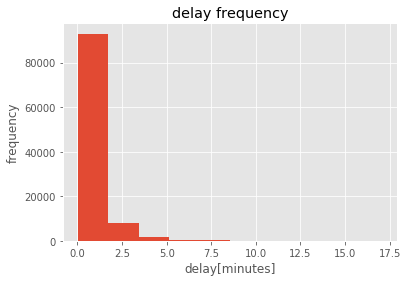

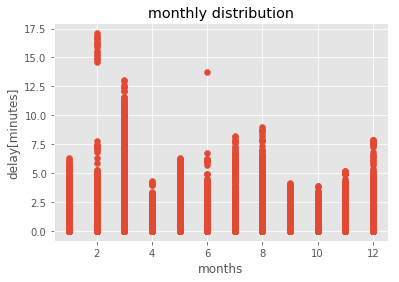

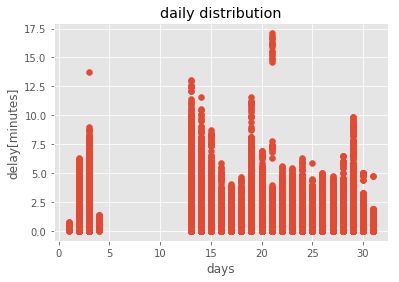

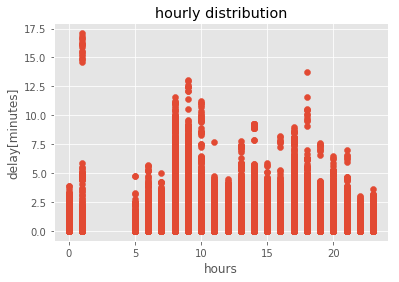

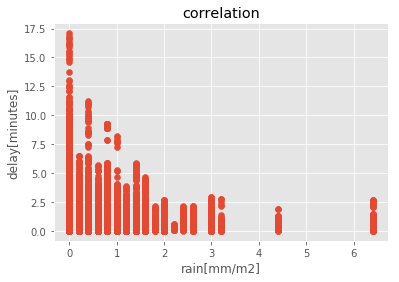

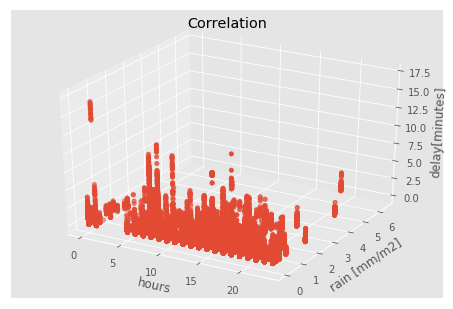

r-squared value between rain and delay: 0.0001416678333665578


In [6]:
from mpl_toolkits.mplot3d import Axes3D

style.use("ggplot")

# === output folder
newpath = r'./output/'
if os.path.exists(newpath):
    shutil.rmtree(newpath, ignore_errors=True)
os.makedirs(newpath)

month = merge.copy()
day = merge.copy()
hour = merge.copy()

month['time'] = month.loc[:, 'time'].apply(lambda x: x.month)
day['time'] = day.loc[:, 'time'].apply(lambda x: x.day)
hour['time'] = hour.loc[:, 'time'].apply(lambda x: x.hour)

# === csv to check output data
# merge.to_csv('./output/merge.csv', header=False, index=False)
# wet.to_csv('./output/wet.csv', header=False, index=False)
# df1.to_csv('./output/df1.csv', header=False, index=False)

# === frequency histogramm
plt.hist(merge.loc[:, 'diff'])
plt.title("delay frequency")
plt.xlabel("delay[minutes]")
plt.ylabel("frequency")
plt.savefig('./output/2Dfrequency.png', format='png', dpi=800)
plt.show()

# === 2D monthly distribution of delays
x = month.loc[:, 'time']
y = month.loc[:, 'diff']
plt.scatter(x, y)
plt.title("monthly distribution")
plt.xlabel("months")
plt.ylabel("delay[minutes]")
plt.savefig('./output/2Dmonthly.png', format='png', dpi=800)
plt.show()

# === 2D daily distribution of delays
x = day.loc[:, 'time']
y = day.loc[:, 'diff']
plt.scatter(x, y)
plt.title("daily distribution")
plt.xlabel("days")
plt.ylabel("delay[minutes]")
plt.savefig('./output/2Ddaily.png', format='png', dpi=800)
plt.show()

# === 2D hourly distribution of delays
x = hour.loc[:, 'time']
y = hour.loc[:, 'diff']
plt.scatter(x, y)
plt.title("hourly distribution")
plt.xlabel("hours")
plt.ylabel("delay[minutes]")
plt.savefig('./output/2Dhourly.png', format='png', dpi=800)
plt.show()

# === 2D dependency on rain
x = merge.loc[:, 'rain']
y = merge.loc[:, 'diff']
plt.scatter(x, y)
plt.title("correlation")
plt.xlabel("rain[mm/m2]")
plt.ylabel("delay[minutes]")
plt.savefig('./output/2Drain-delay.png', format='png', dpi=800)
plt.show()

# === 3D Figure rain, time, delay
x = hour.loc[:, 'time']
y = hour.loc[:, 'rain']
z = hour.loc[:, 'diff']
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x, y, z)
plt.title("Correlation")
ax.set_xlabel('hours')
ax.set_ylabel('rain [mm/m2]')
ax.set_zlabel('delay[minutes]')
plt.savefig('./output/3DcorrelationHourly.png', format='png', dpi=800)
plt.show()

# === other statistics on data

# print(merge.loc[:,'rain'].describe())
# print(merge.loc[:,'diff'].describe())

slope, intercept, r_value, p_value, std_err = stats.linregress(merge.loc[:, 'rain'], merge.loc[:, 'diff'])
print("r-squared value between rain and delay:", r_value ** 2)


## Prediction

In [ ]:
from sklearn.svm import SVC


X = merge.loc[:, 'rain']
y = merge.loc[:, 'diff']

clf = SVC()
clf.fit(X, y)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
pred = clf.predict(merge.loc[:, ['rain']])
plt.scatter(merge.loc[:, ['rain']], pred)
plt.ylabel('predicted delay [s]')
plt.xlabel('precipitation [mm/h]')
plt.savefig('./output/prediction.png', format='png', dpi=800)
plt.show()
